In [ ]:
%%capture
! pip install arviz
!pip install pymc3==3.9.3

In [ ]:
import pymc3 as pm
from theano import tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Import data

In [ ]:
merged_df = pd.read_csv('Merged.txt')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,24,25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
np.arange(-40.5, 41, 0.5).shape

(163,)

In [ ]:
subjects = merged_df.Subject.unique()[:8]
nSub = len(subjects)
x = np.zeros((nSub, 163))
n = np.zeros((nSub, 163))
r = np.zeros((nSub, 163))

for i, sub in enumerate(subjects):

  for modality in (['Intero']):
      this_df = merged_df[(merged_df.Modality == modality) & (merged_df.Subject == sub)]
      data = pd.DataFrame([])
      for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
          # Store results
          x[i, ii] = intensity
          n[i, ii] = sum(this_df.Alpha == intensity)
          r[i, ii] = sum((this_df.Alpha == intensity) & (this_df.Estimation == 'More'))
rprop = r/n

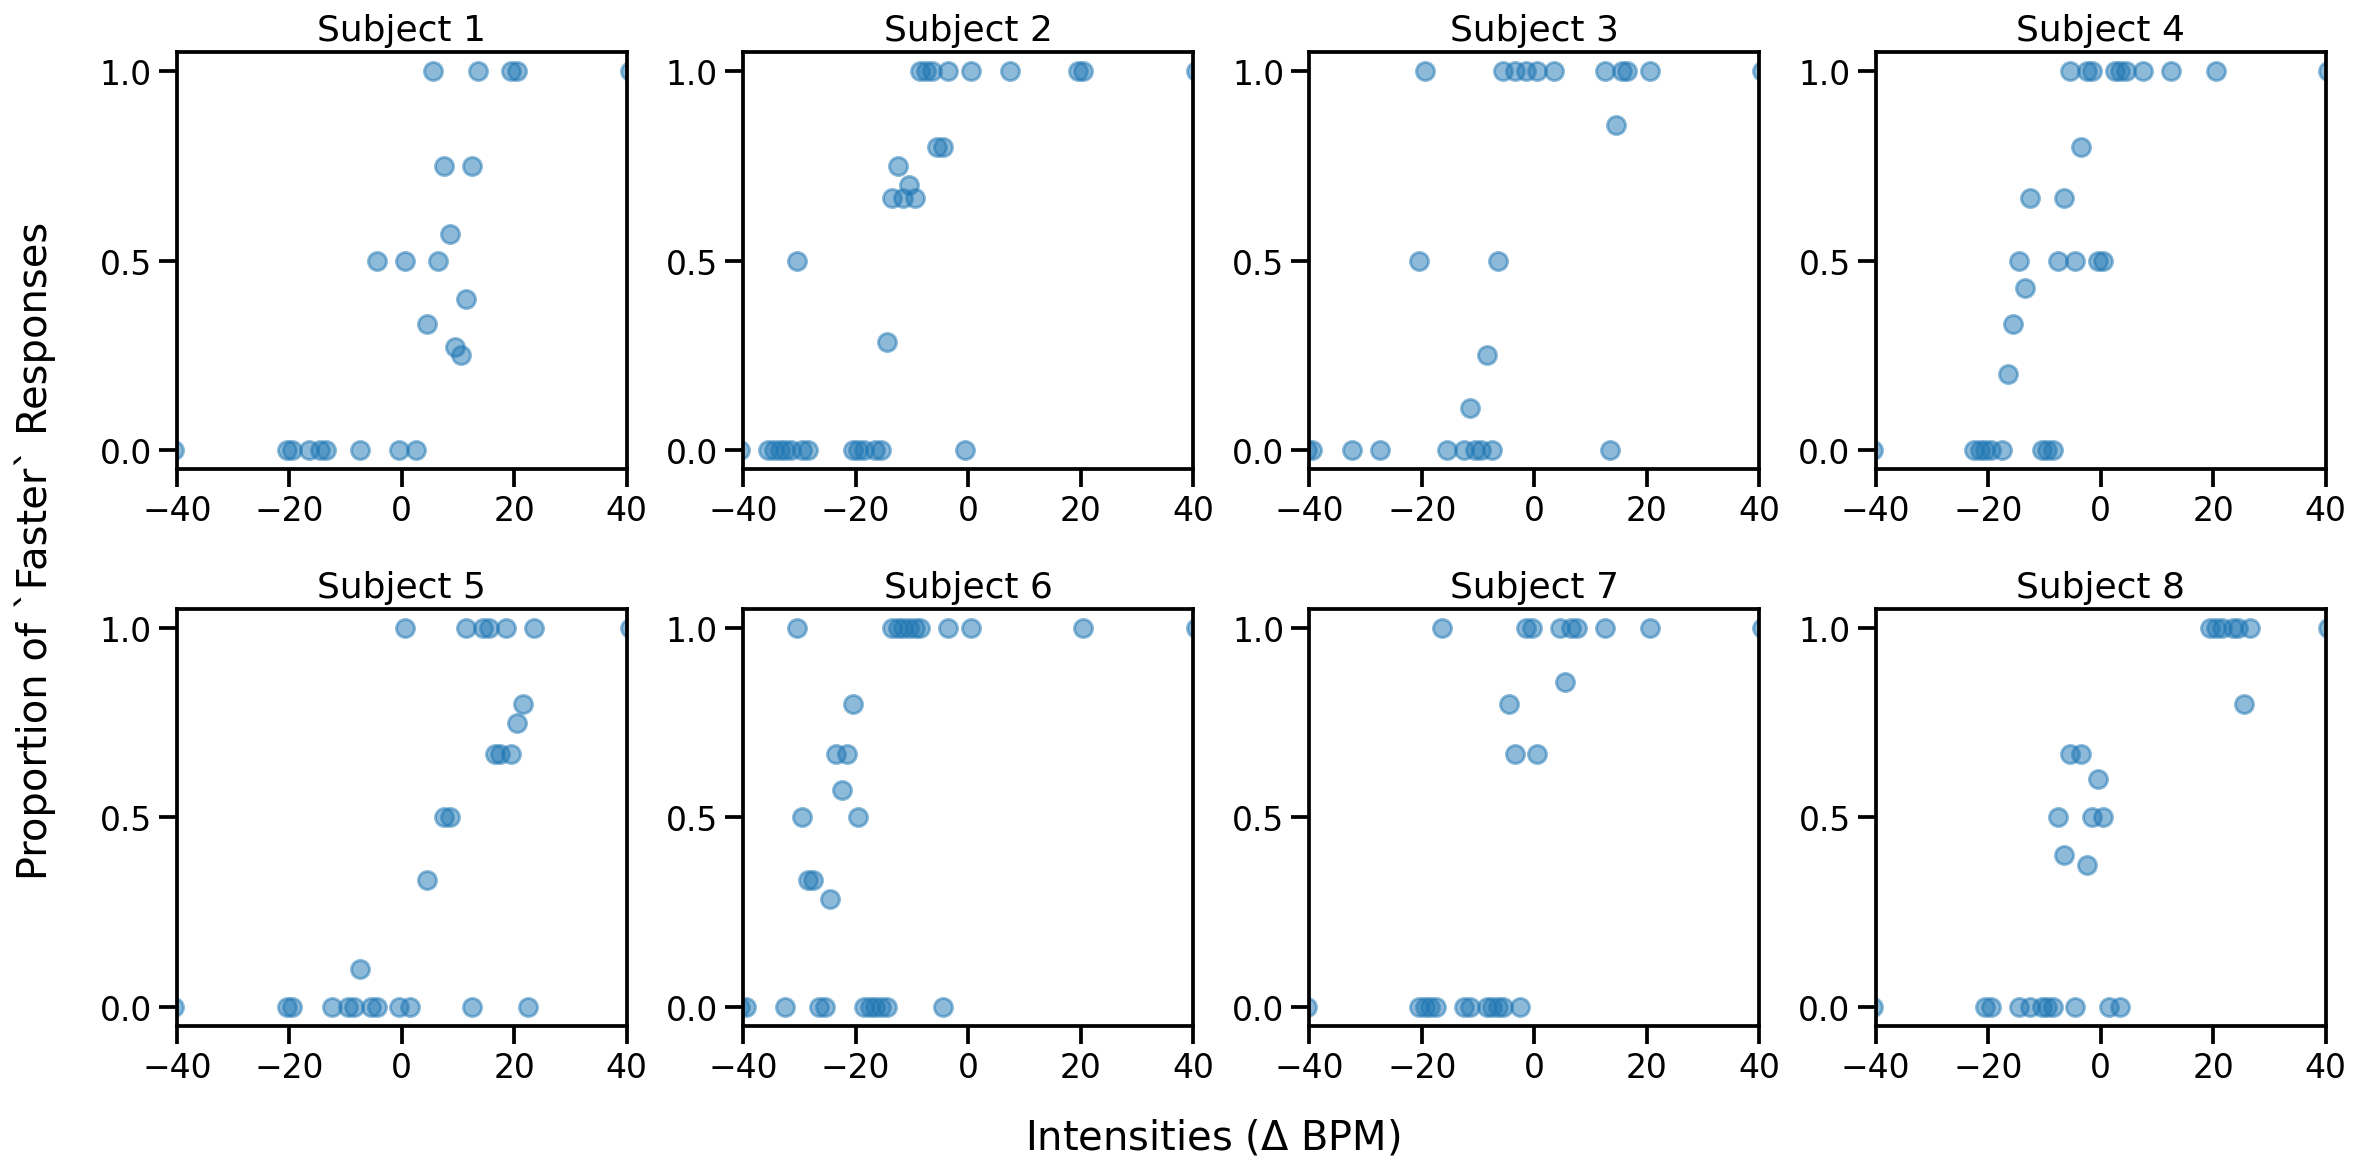

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.set_context('talk')
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Intensities ($\Delta$ BPM)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of `Faster` Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

for ip, sub in enumerate(subjects):
    ax = plt.subplot(gs[ip])
    xp = np.array(x[ip, :])
    yp = np.array(rprop[ip, :])
    ax.scatter(xp, yp, marker='o', alpha=.5)
    plt.xlim(-40, 40)
    plt.yticks((0, .5, 1))
    plt.title('Subject %s'%(ip+1))

plt.tight_layout()
plt.show()
sns.despine()

In [ ]:
def phi(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + pm.math.erf(x / pm.math.sqrt(2.0))) / 2.0
def Phi(x):
    # probit transform 
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))
def tlogit(x):
    return 1/(1+tt.exp(-x))

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [ ]:
xij_tmp = x.copy()
nij_tmp = n.copy()
rij_tmp = r.copy()
tmp, nstim2 = np.shape(xij_tmp)

xmean = np.nanmean(xij_tmp, axis=1)
xmeanvect = np.repeat(xmean, nstim2)
sbjidx = np.repeat(np.arange(nSub), nstim2)

xmeanvect = np.repeat(xmean, nstim2)
sbjidx = np.repeat(np.arange(nSub), nstim2)

# remove nans
validmask = np.isnan(xij_tmp.flatten())==False
xij2 = xij_tmp.flatten()
nij2 = nij_tmp.flatten()
rij2 = rij_tmp.flatten()

xij = xij2[validmask]
nij = nij2[validmask]
rij = rij2[validmask]
xvect = xmeanvect[validmask]
sbjid = sbjidx[validmask]

In [ ]:
with pm.Model() as model1:

    # Variance priors
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=1000)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=1000)
   
    # Mean priors
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)

    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nSub)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nSub)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    thetaij = pm.Deterministic('thetaij', tlogit(linerpredi))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)
    trace1 = pm.sample(1000, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 61300
Interrupted at 61,299 [30%]: Average Loss = 284.74
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha, mu_b, mu_a, sigma_b, sigma_a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 34 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199749488797289, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


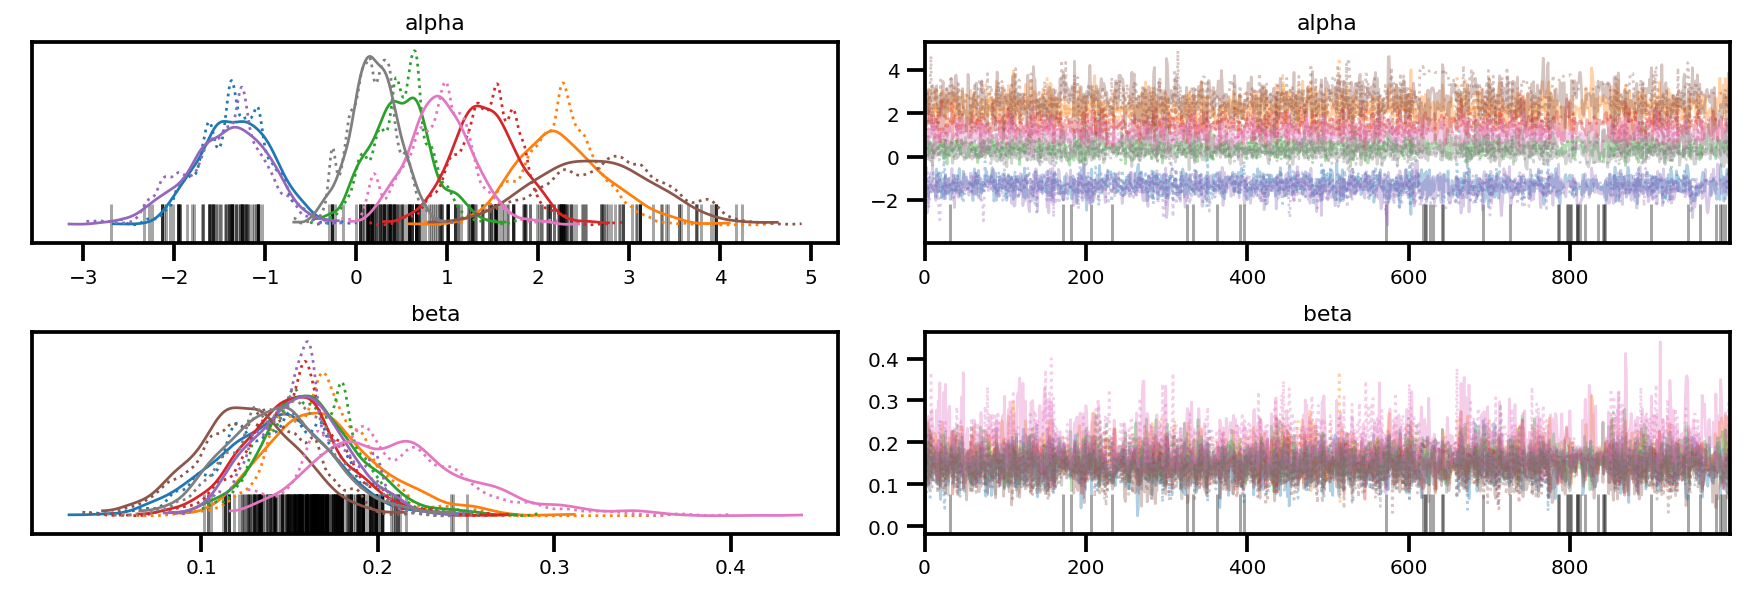

In [ ]:
pm.traceplot(trace1, varnames=['alpha', 'beta']);

In [ ]:
alphaMAP

alpha[0]   -1.323
alpha[1]    2.256
alpha[2]    0.496
alpha[3]    1.437
alpha[4]   -1.438
alpha[5]    2.670
alpha[6]    0.916
alpha[7]    0.189
Name: mean, dtype: float64

/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


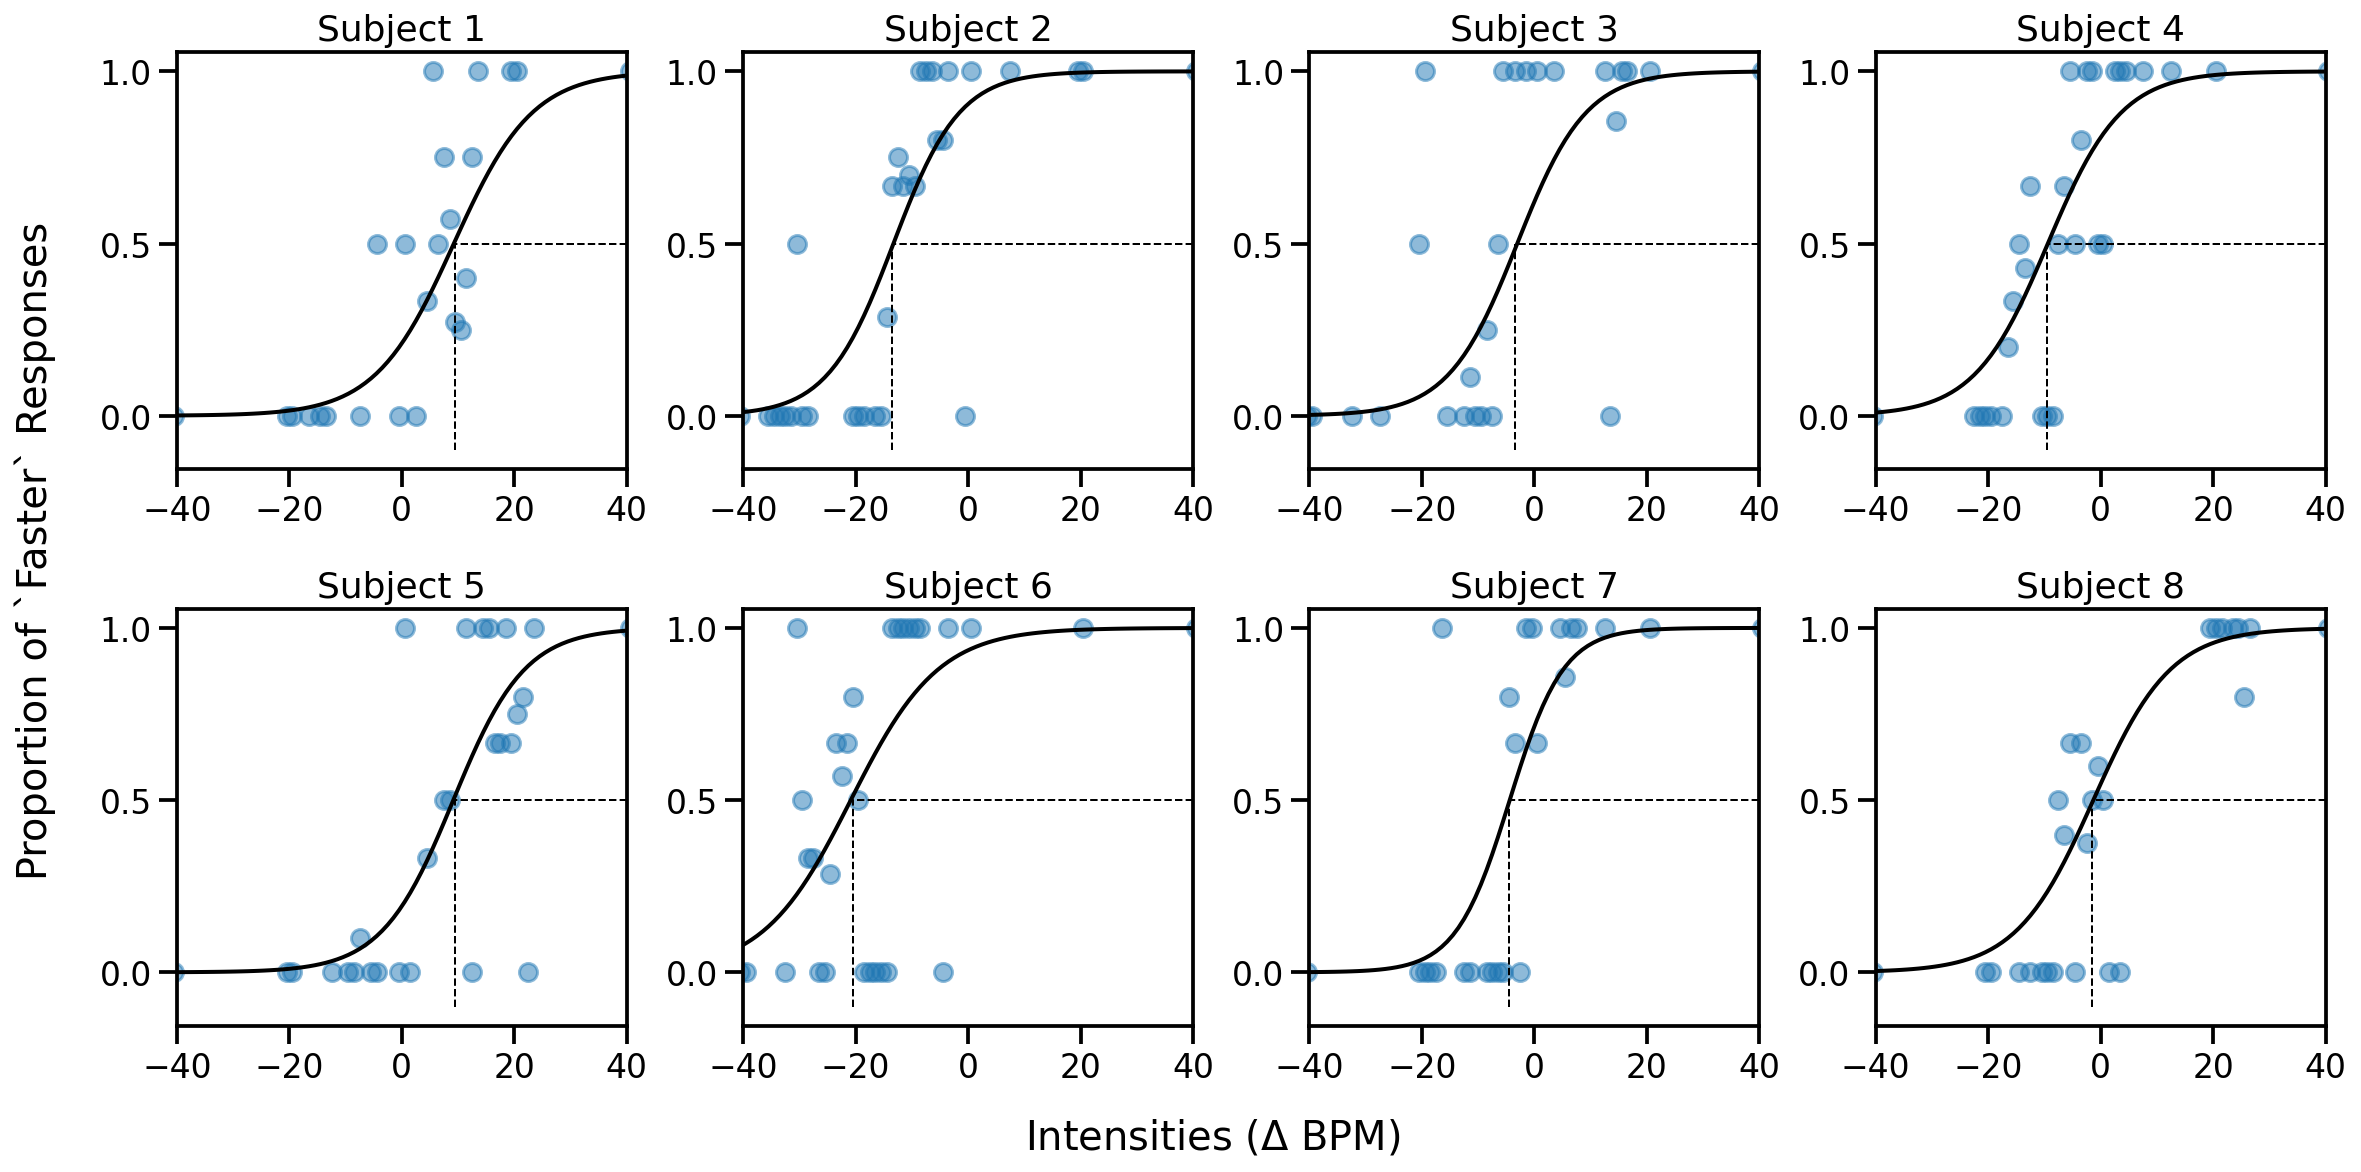

In [ ]:
def logit(x):
    return 1/(1+np.exp(-x))

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Intensities ($\Delta$ BPM)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of `Faster` Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

burnin = 0
# get MAP estimate
tmp = pm.summary(trace1[burnin:], varnames=['alpha', 'beta'])
alphaMAP = tmp['mean'][np.arange(nSub)]
betaMAP = tmp['mean'][np.arange(nSub)+nSub]

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nSub):
    ax = plt.subplot(gs[ip])
    xp = np.array(x[ip, :])
    yp = np.array(rprop[ip, :])
    ax.scatter(xp, yp, marker='o', alpha=.5)
    
    xl = np.arange(-40.5, 40.5)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot([x1, x1],[-.1, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([40, x1],[.5, .5], color='k', linestyle='--', linewidth=1)

    plt.xlim(-40, 40)
    plt.yticks((0, .5, 1))
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()

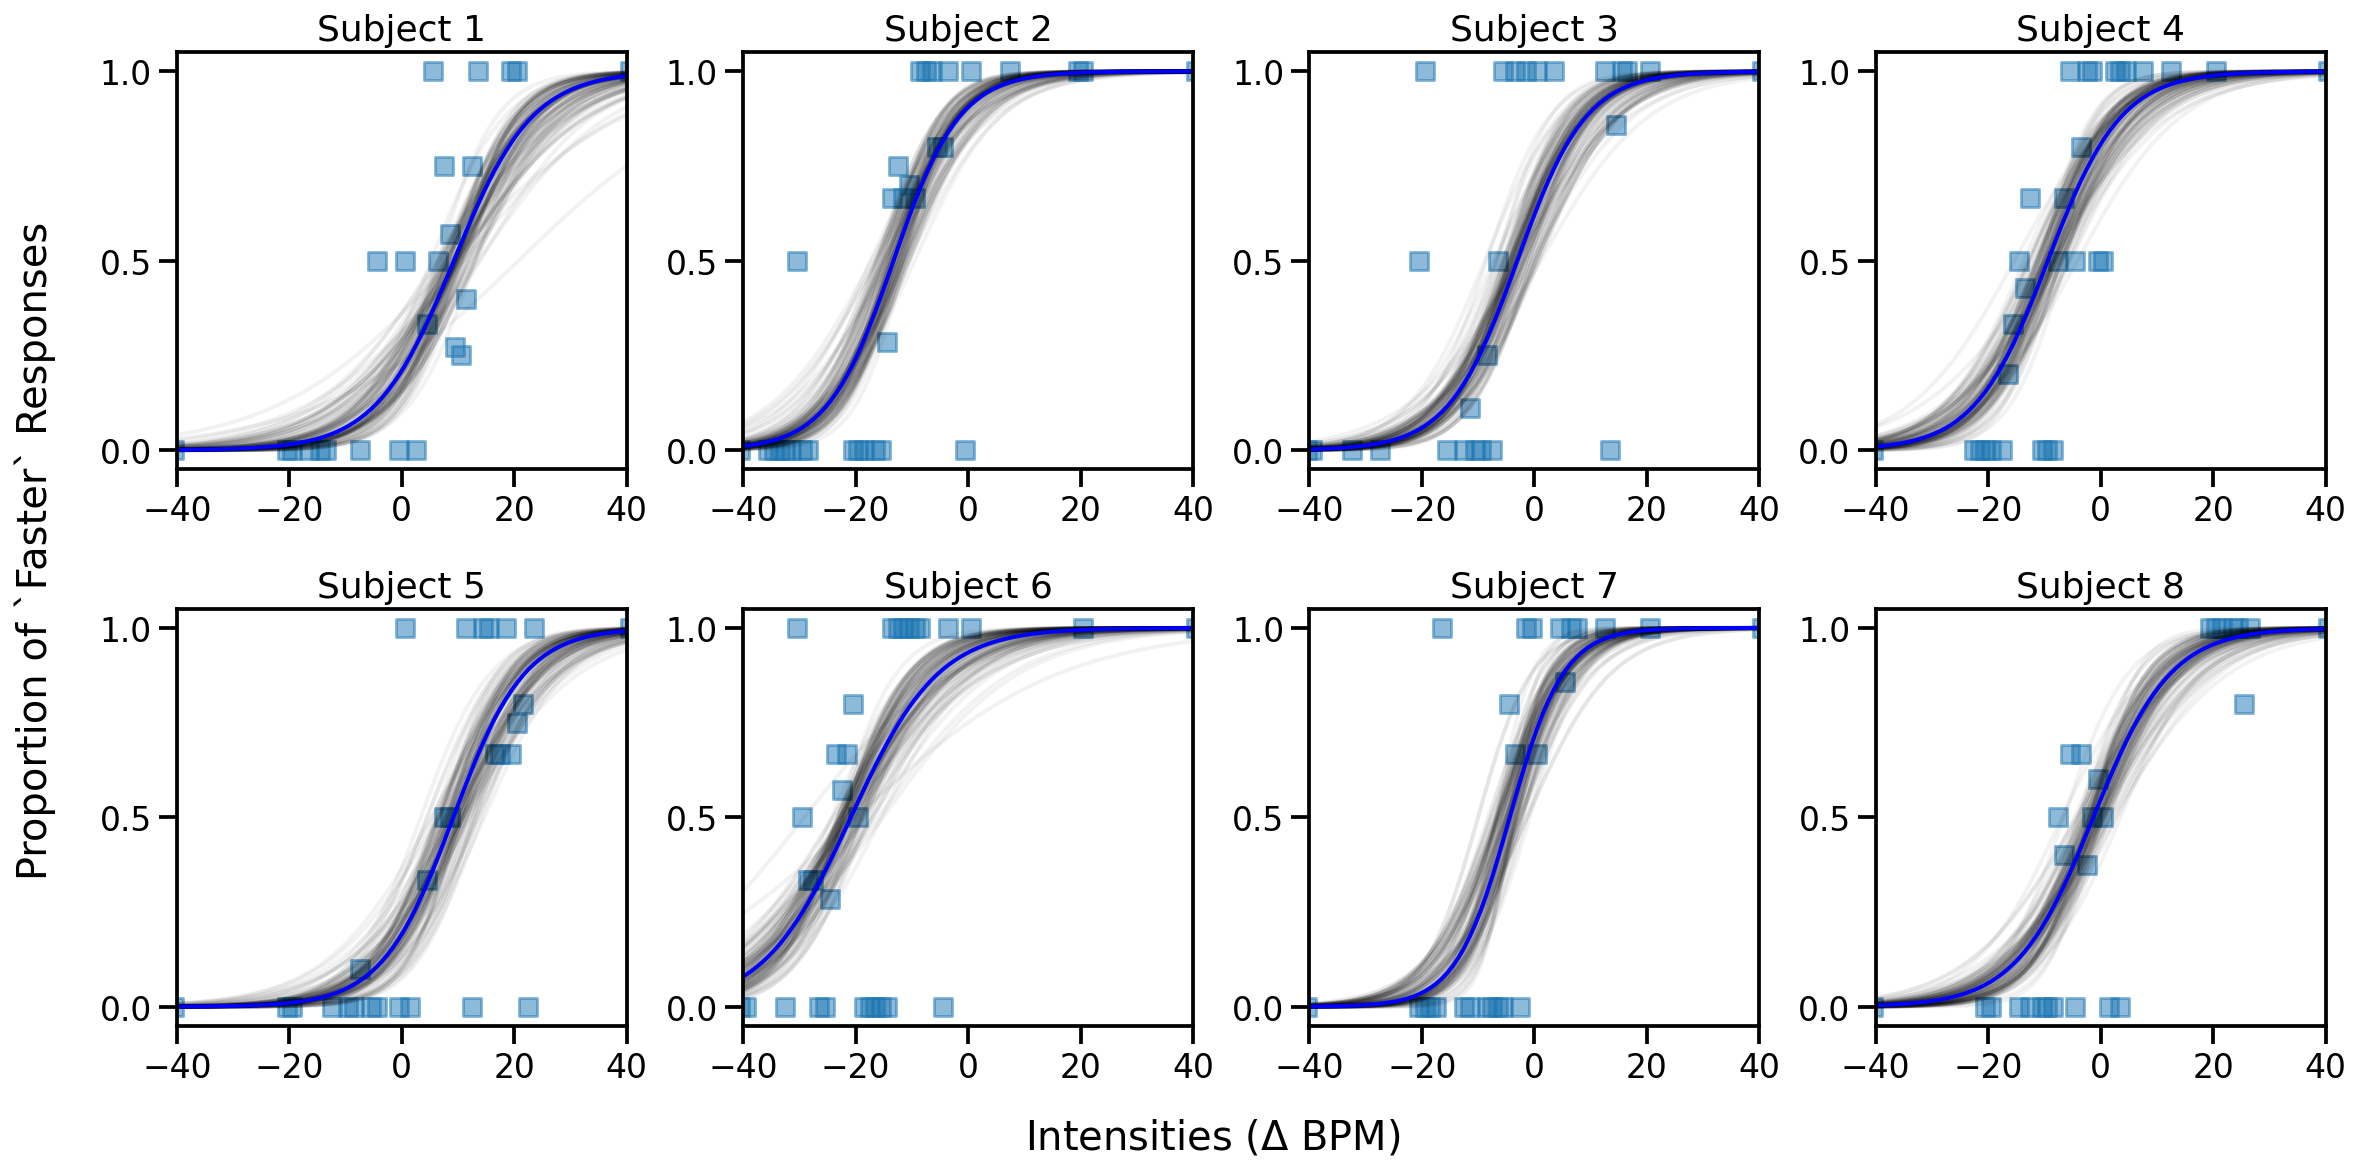

In [ ]:
# PLOT FOR EXERCISE 12.1.2 
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Intensities ($\Delta$ BPM)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of `Faster` Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

ppcsamples=100

for ip in np.arange(nSub):
    ax = plt.subplot(gs[ip])
    xp = np.array(x[ip, :])
    yp = np.array(rprop[ip, :])
    ax.scatter(xp, yp, marker='s', alpha=.5)
    
    xl = np.arange(-40.5, 40.5)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))

    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 1e3, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        plt.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    plt.plot(xl, yl, 'b', linewidth=2)
    plt.xlim(-40, 40)
    plt.yticks((0, .5, 1))
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()

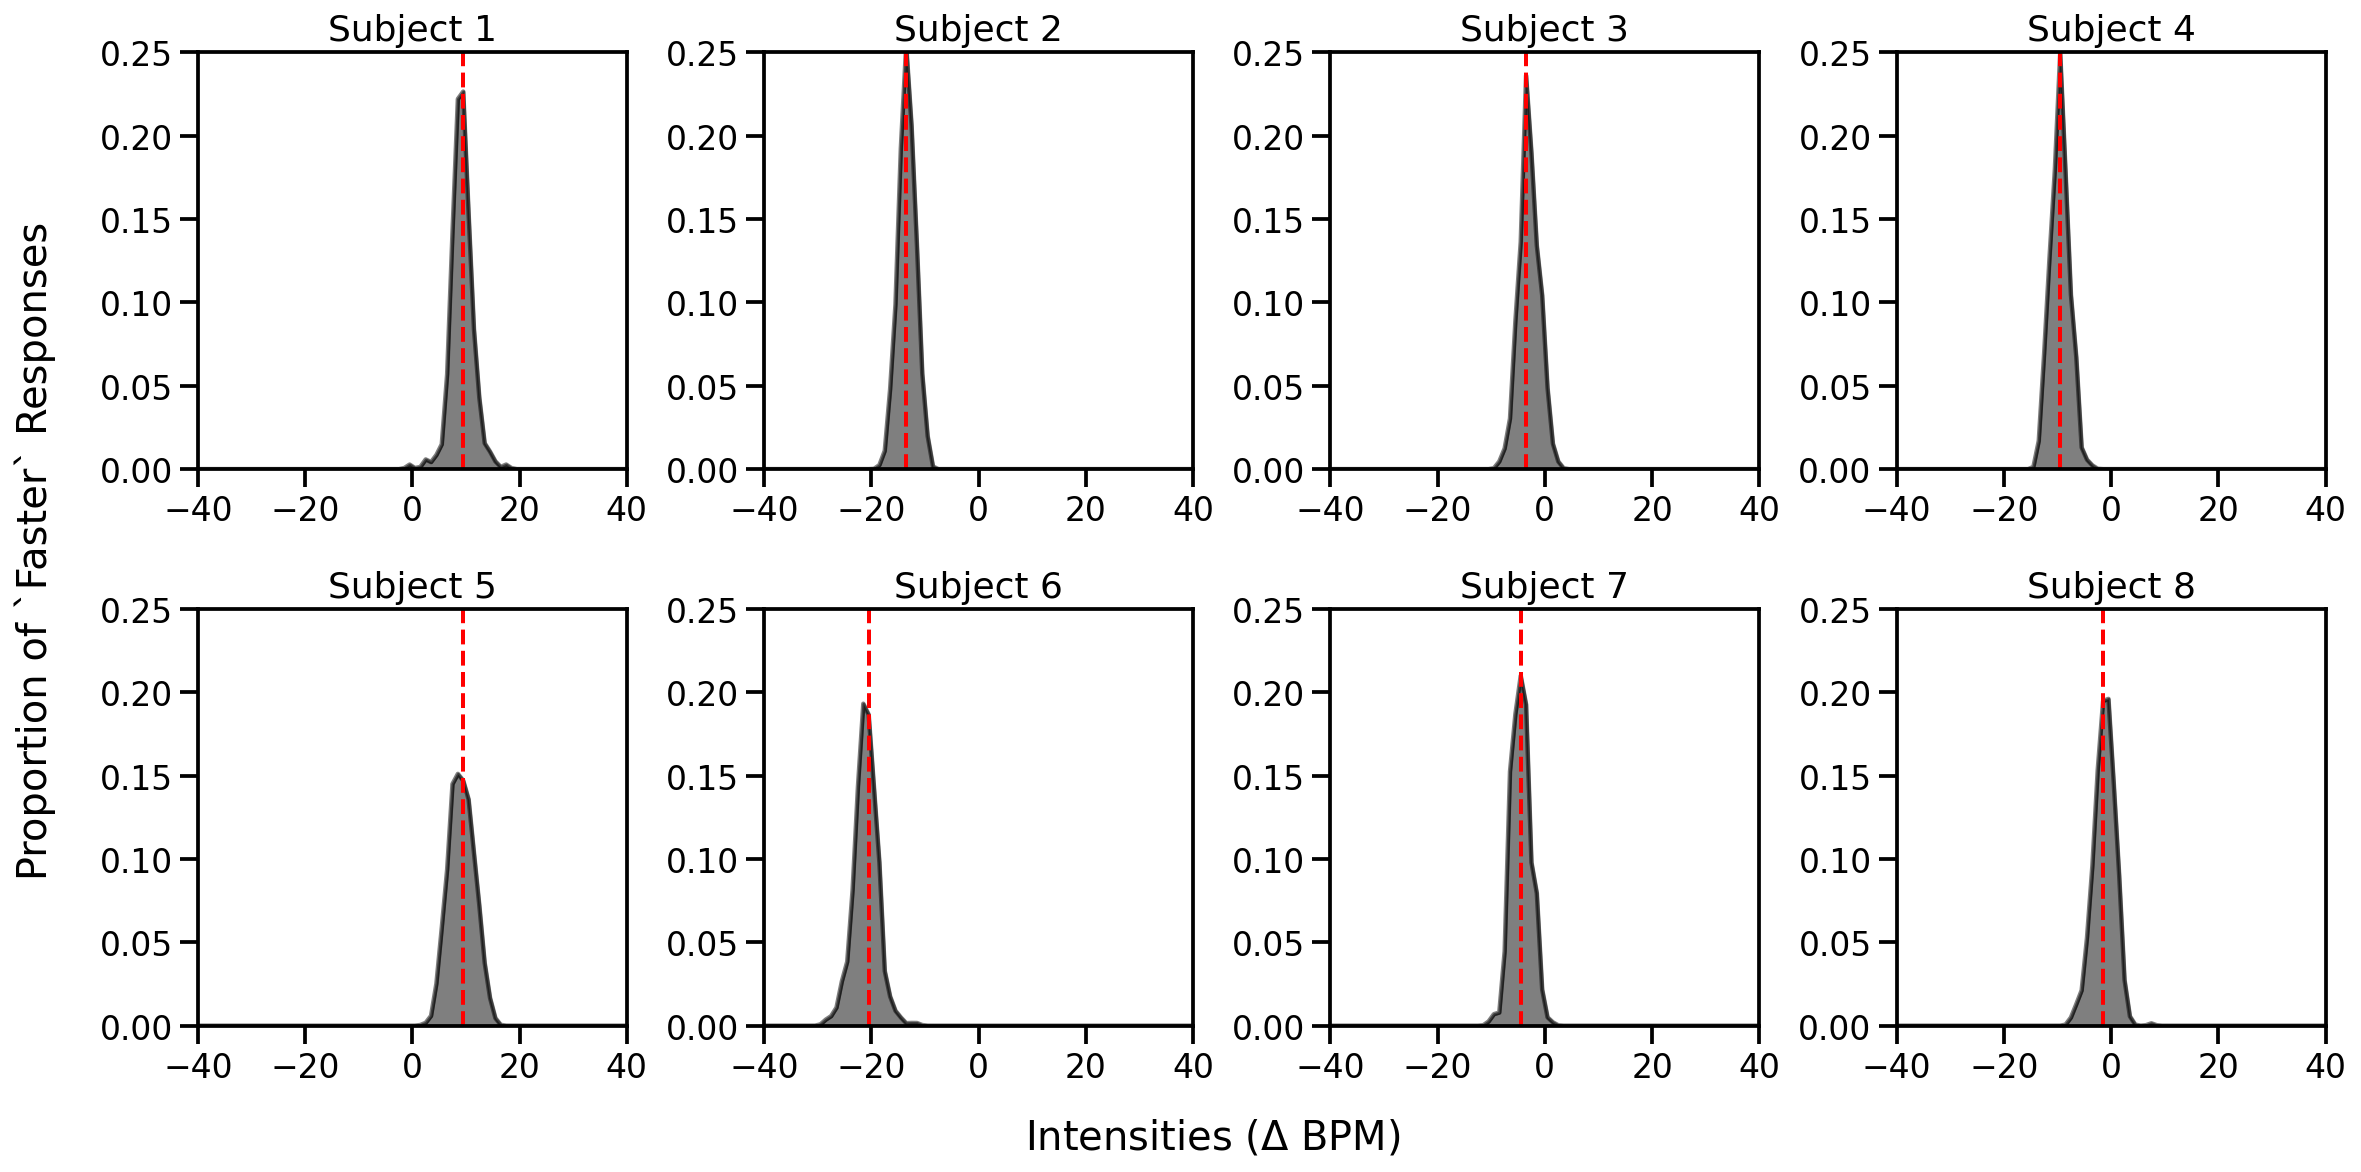

In [ ]:
# PLOT FOR EXERCISE 12.1.4 
from scipy.stats.kde import gaussian_kde # for plotting: to calculate a continuous 
                                         # approximation of the posterior and prior densities. 

fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Intensities ($\Delta$ BPM)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of `Faster` Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

ppcsamples=500

for ip in np.arange(nSub):
    ax = plt.subplot(gs[ip])
    
    xl = np.arange(-40.5, 40.5)
    yl = logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    jnd1 = x1
    
    # Posterior sample
    jndps=[]
    for ips in np.random.randint(burnin, 1e3, ppcsamples):
        param = trace1[ips]
        yl2 = logit(param['alpha'][ip] + param['beta'][ip]*(xl-xmean[ip]))
        x1 = xl[find_nearest(yl2, .5)]
        jndps.append(x1)
        
    pdfpc = gaussian_kde(jndps)
    x2=np.arange(-40.5, 40.5)
    plt.plot(xl, pdfpc(xl), 'k', alpha=.5) 
    plt.fill_between(xl, pdfpc(xl), 0, alpha=.5, color='k')
    plt.axvline(jnd1, color='r', ls='--', lw=2)
    
    plt.xlim(-40, 40)
    plt.ylim(0, .25)
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()

# Psychophysical functions under contamination

In [ ]:
with pm.Model() as model2b:
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=1000)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=1000)
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nSub)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nSub)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    
    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=nSub, testval=np.ones(nSub))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=xij.shape)
    
    # reparameterized so we can use ADVI initialization
    # zij_ = pm.Uniform('zij_',lower=0, upper=1, shape=xij.shape)
    # zij = pm.Deterministic('zij', tt.lt(zij_, phii[sbjid]))
    
    # rng = tt.shared_randomstreams.RandomStreams()
    # zij_ = rng.binomial(n=1, p=phii[sbjid], size=xij.shape)
    zij_ = pm.theanof.tt_rng().uniform(size=xij.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[sbjid]))
    # zij = pm.Deterministic('zij', tt.eq(zij_, 0))
    
    thetaij = pm.Deterministic('thetaij', tt.switch(zij, tlogit(linerpredi), pi_ij))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)

Finished [100%]: Average Loss = 343.53


Finished [100%]: Average Loss = 329.81
/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


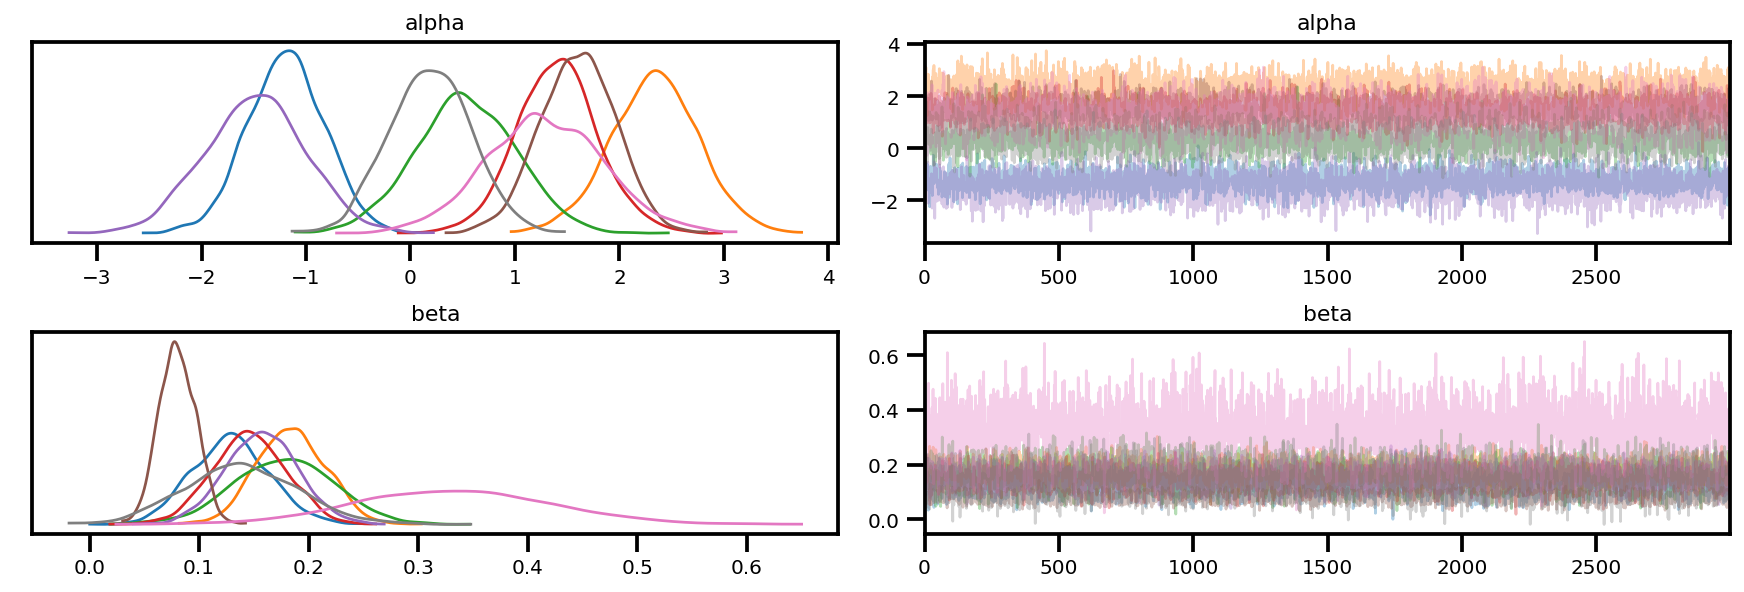

In [ ]:
import theano
with model2b:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace2b = approx.sample(3000, include_transformed=True) 
    elbos1 = -inference.hist
    
pm.traceplot(trace2b, varnames=['alpha', 'beta']);

In [1]:
with pm.Model() as model2b_:
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=1000)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=1000)
    mu_a = pm.Normal('mu_a', mu=0, tau=.001)
    mu_b = pm.Normal('mu_b', mu=0, tau=.001)
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=nSub)
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=nSub)
    
    linerpredi = alpha[sbjid] + beta[sbjid]*(xij-xvect)
    
    # latent model for contamination
    sigma_p = pm.Uniform('sigma_p', lower=0, upper=3)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)
    
    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=nSub, testval=np.ones(nSub))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=xij.shape)
    
    # place holder if zij_ is in the graph in the previous model
    #zij_ = pm.Uniform('zij_',lower=0, upper=1, shape=xij.shape)
    
    zij = pm.Bernoulli('zij', p=phii[sbjid], shape=xij.shape)
    thetaij = pm.Deterministic('thetaij', tt.switch(tt.eq(zij, 0), tlogit(linerpredi), pi_ij))
    
    rij_ = pm.Binomial('rij', p=thetaij, n=nij, observed=rij)

NameError: name 'pm' is not defined

In [ ]:
from pymc3.step_methods.hmc import quadpotential

nchains = 2
cov = np.atleast_1d(pm.trace_cov(trace2b, model=model2b))
start = list(np.random.choice(trace2b, nchains))
for ic in range(nchains):
    start[ic]['zij'] = start[ic]['zij'].astype(int)
potential = quadpotential.QuadPotentialFull(cov)
step = pm.NUTS(potential=potential, model=model2b_, vars=model2b_.free_RVs[:-1])

with model2b_:
    trace2b_ = pm.sample(10, tune=10,
                         step=step, start=start, chains=nchains, cores=4)

Only 10 samples in chain.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [pi_ij, probitphi, mu_p, sigma_p, beta, alpha, mu_b, mu_a, sigma_b, sigma_a]
>BinaryGibbsMetropolis: [zij]


Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 57 seconds.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:629: UserWarning: The number of samples is too small to check convergence reliably.
  "The number of samples is too small to check convergence reliably."
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument 

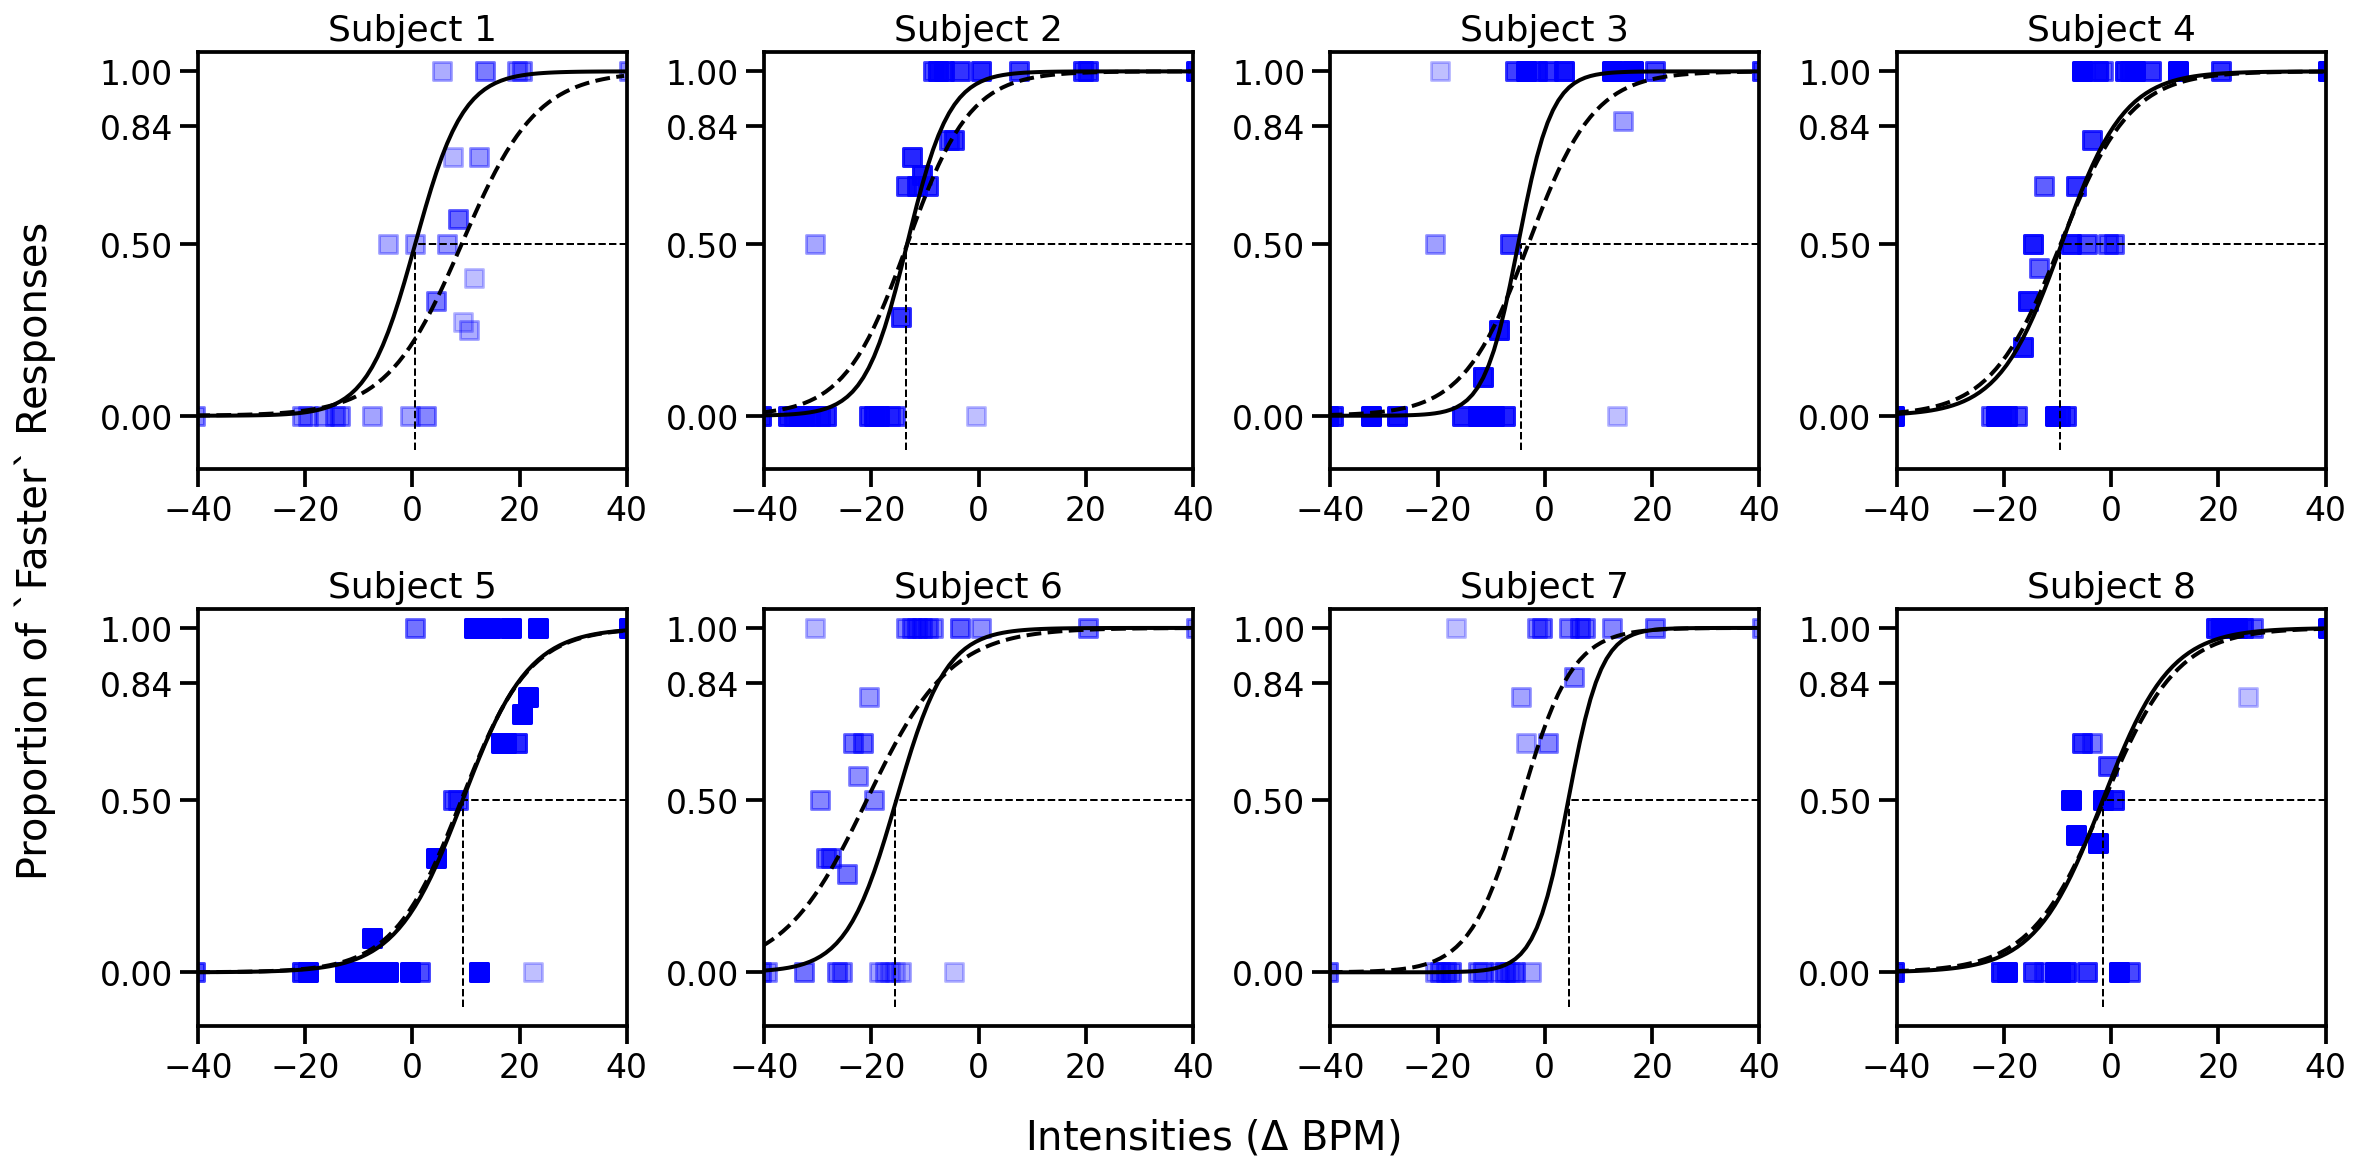

In [ ]:
# reproduce figure 12.6
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Intensities ($\Delta$ BPM)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of `Faster` Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(2, 4)

trace2 = trace2b_
burnin = 0
# get MAP estimate
tmp = pm.summary(trace2[burnin:], varnames=['alpha', 'beta'])
tmp2 = pm.summary(trace2[burnin:], varnames=['zij'])

alphaMAP2 = tmp['mean'][np.arange(nSub)]
betaMAP2 = tmp['mean'][np.arange(nSub)+nSub]

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

for ip in np.arange(nSub):
    ax = plt.subplot(gs[ip])
    xp = np.array(x[ip, :])
    yp = np.array(rprop[ip, :])
    v1 = np.asarray(tmp2['mean'][sbjid==ip])
    rgbclr = np.zeros((len(v1),4))
    rgbclr[:,2] = 1
    # scale the alpha here - lighter color indicates less weight in the model (i.e., outliner)
    rgbclr[:,3] = 1 - v1/v1.max()*.75
    ax.scatter(xp, yp, marker='s', color=rgbclr)
    
    xl = np.arange(-40.5, 40.5)
    yl = logit(alphaMAP2[ip] + betaMAP2[ip]*(xl-xmean[ip]))
    yl2= logit(alphaMAP[ip] + betaMAP[ip]*(xl-xmean[ip]))
    x1 = xl[find_nearest(yl, .5)]
    x2 = xl[find_nearest(yl, .84)]

    plt.plot(xl, yl, 'k', linewidth=2)
    plt.plot(xl, yl2, 'k', linestyle='--', linewidth=2)
    plt.plot([x1, x1], [-.1, .5], color='k', linestyle='--', linewidth=1)
    plt.plot([40, x1], [.5, .5], color='k', linestyle='--', linewidth=1)

    plt.xlim(-40, 40)
    plt.yticks((0, .5, .84, 1))
    plt.title('Subject %s'%(ip+1))
    
plt.tight_layout()
plt.show()